<a href="https://colab.research.google.com/github/dcsw2/ddh/blob/main/DW_Working_with_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is an interactive Jupyter Notebook written in Python 🐍
## It includes example scripts and provides access to some sample newspaper data
#### It was developed, written and adapted by Nilo Pedrazzini, Kaspar Beelen and Daniel Wilson
---
# Getting to know a digitized corpus: Working with OCR'd material and OCR errors



In what follows, we'll mainly use `pandas` as a data manipulation tool:

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', 50)

Import sample of newspapers from CSV file:

In [ ]:
!gdown 'https://drive.google.com/uc?id=1lxapBFOTK9aKu-GgTQZ5wYsrgqpWLba7'
df = pd.read_csv('/content/subsample500mixedocr-selected_mitch.csv')
df.sample(3)

Downloading...
From: https://drive.google.com/uc?id=1lxapBFOTK9aKu-GgTQZ5wYsrgqpWLba7
To: /content/subsample500mixedocr-selected_mitch.csv
100% 1.59M/1.59M [00:00<00:00, 41.5MB/s]


,publication_code,issue_id,item_id,newspaper_title,data_provider,date,year,month,day,location,word_count,ocrquality,political_leaning_label,price_label,text
47,2616,220,art0049,The Tamworth Examiner and Working Men's Journal.,British Library Living with Machines Project,1875-02-20,1875,2,20,"Tamworth, Staffordshire, England",223,0.9644,NaN,NaN,"THE SHEFFIELD The above is a MICROSCOPE, with..."
6,2596,626,art0016,The Cotton Factory Times.,British Library Living with Machines Project,1903-06-26,1903,6,26,"Manchester, Greater Manchester, England",1991,0.9578,neutral,1d,Whiffles. CHAPTER lll.—(Continued.) A high co...
435,3065,427,art0038,The Haslingden Gazette.,British Library Living with Machines Project,1907-04-27,1907,4,27,"Haslingden, Lancashire, England",388,0.8002,conservative,1d,GREEN TEA. Prom among the host of sixpenny no...


### 'Word' counts

⏭️ Check the size of the dataset. Generally, one way of giving an idea of this is in terms of **number of words**.

A crude way to check the total number of "words" is by splitting all the text at any whitespace character (spaces (`\s`), newlines (`\n`), and tabs (`\t`)) and counting how many units we got as a result.

Note: because of huge differences in OCR quality from text to text, this method will often not be precise.

In [ ]:
# Calculate total word count from text column
# split() means 'split at any whitepoint character'.
# You could specify a whitespace instead, e.g. '\s', which would exclude tabs and newlines.
total_word_count = df['text'].apply(lambda x: len(str(x).split())).sum()
print(f"Total Word Count: {total_word_count}")

Total Word Count: 257684


⏭️ We can add a column to our text sample, detailing how many words each 'item' (i.e. roughly 'article') has.

> ⚠️ **Note**: a word count is included in the newspaper matadata for our collections, but this gives you more control if you want to add a rule of your choosing, e.g. if you know of regularities in OCR errors and want to keep those into account.

In [ ]:
df['word_count'] = [len(x.split(' ')) for x in df['text'].astype(str)]

This way we can check how many words each title, for example, has represented in our dataset, or check the title with the highest number of words:

In [ ]:
df.groupby(['newspaper_title']).agg(total_words=('word_count', 'sum')).reset_index().sort_values(by='total_words',ascending=False)

,newspaper_title,total_words
33,The Birkenhead News and Wirral General Adverti...,31818
38,The Cotton Factory Times.,19868
72,Widnes Examiner.,14131
41,The Dorset County Express and Agricultural Gaz...,11888
8,"Bridport, Beaminster, and Lyme Regis Telegram ...",11274
...,...,...
55,The Pontypridd District Herald and Rhondda Val...,110
40,"The Dewsbury Chronicle, and West Riding Advert...",82
44,The Halifax Comet.,30
10,Brighouse Gazette and Local Railway Guide.,27


⏭️ We can use the `year` to check the **temporal coverage** of the sample and visualize how many tokens each year has, regardless of title (let's use the full sample here):

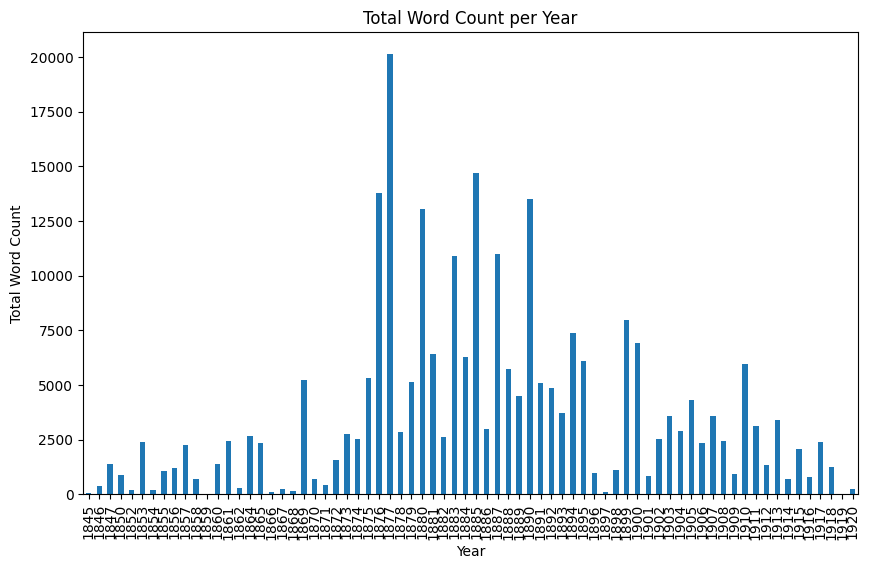

In [ ]:
import matplotlib.pyplot as plt

# group by year and sum the word_count
word_count_by_year = df.groupby('year')['word_count'].sum()

# plot the summed word count over the years
plt.figure(figsize=(10, 6))
word_count_by_year.sort_index().plot(kind='bar')
plt.title('Total Word Count per Year')
plt.xlabel('Year')
plt.ylabel('Total Word Count')
plt.show()



We can also check how many items we have per year. *Items* are supposed to be coherent units, ideally articles, from a newspaper page (or possibly across pages, if long). We can then cross the counts of items per year with the counts of words per year.

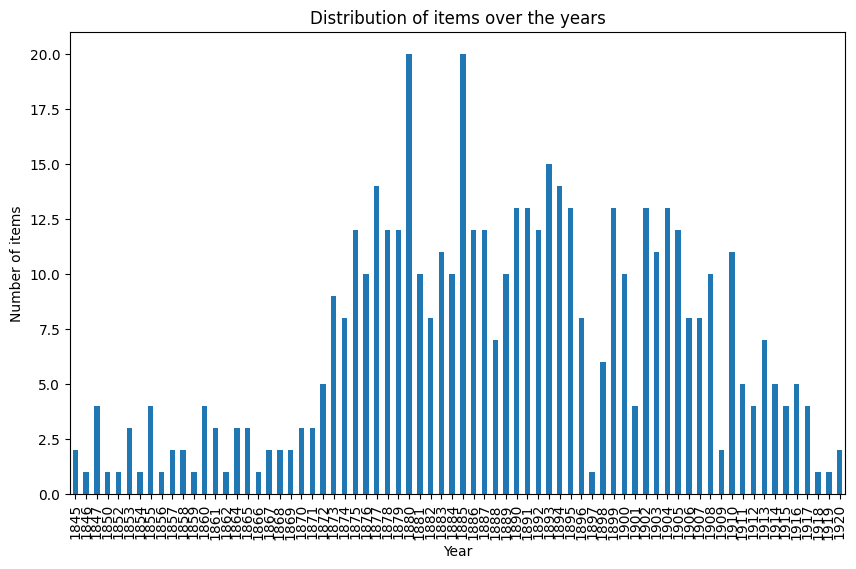

In [ ]:
import matplotlib.pyplot as plt

# plot distribution of items over the years
plt.figure(figsize=(10, 6))
df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of items over the years')
plt.xlabel('Year')
plt.ylabel('Number of items')
plt.show()


We can not only check the first and last date covered by the data, but also get an intuitive first idea of the (im)balance in how many items, versus how many words, we have per period (year in this case).Counting the number of items per year is a _very_ rough approximation of the amount of content per year. This is because:
1) segmentation of newspaper pages into items is far from perfect (as we'll see)
2) even when segmentation _did_ lead to individual articles, articles can vary greatly in length.

**🍜 Food for thought 🧠**
> ❓ **Q**: What are some of the issues that missegmentation may cause to research using digitized newspaper texts as data source?

> ❓ **Q**: Are there research scenarios in which missegmentation of newspaper pages is not a blocker?

> ❓ **Q**: What workarounds can we try out to overcome some of the blockers?

> ✏️ **Exercise (optional)**
>
> Which places of publications are the most frequent in our sample for articles published in the 1850s, 1860s, and 1870s? Generate a plot.

## A closer look at item lengths and segmentation problems

Segmentation into 'items'/'articles' was done automatically, so the we'll often find more than one article counted as one (i.e. one row in our dataframe), or, less frequently, only a portion of one article (i.e. article was cut short). Article length (i.e. number of words) can give us an idea of what's the distribution of wrongly segmented articles.

Let's print some high-level stats about this:

In [ ]:
df['word_count'].describe()

,word_count
count,500.000000
mean,522.226000
std,864.991605
min,1.000000
25%,68.000000
50%,213.500000
75%,510.000000
max,6055.000000


And visualize it:

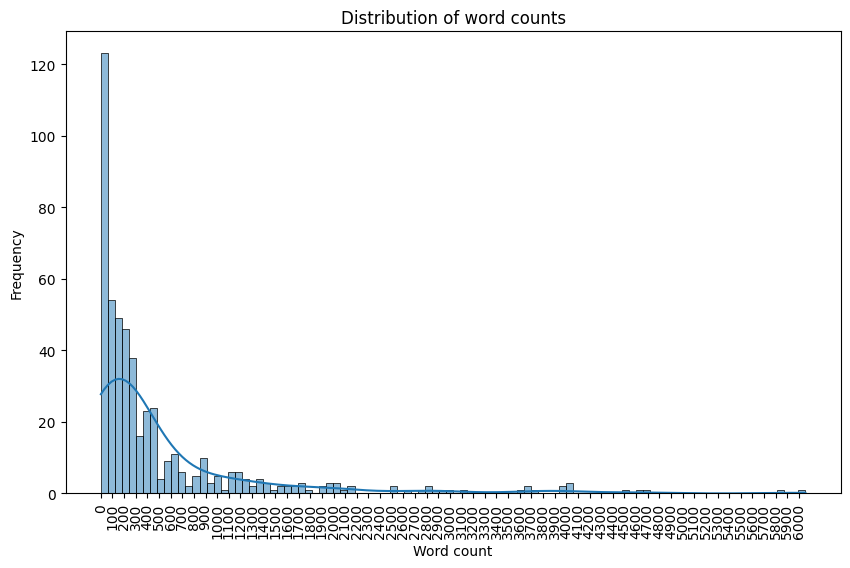

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set max_count for consistent x-ticks
max_count = df['word_count'].max()

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=100, kde=True)
plt.title('Distribution of word counts')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.xticks(range(0, max_count, 100), rotation=90)
plt.show()


As was already clear from the second quartile (50%), or median, from the previous stats, at least half of the items have around 200 words or less. Obviously, an 'item' with 1 word will not repesent an article. Likewise, though, a 6000-word item will also very unlikely represent an article.

### Page missegmentation and identifying articles headlines

One of the main issues in working with digitized historical newspaper is page segmentation. More often than not you'll need to work at the 'article' level, but singling out articles can be challenging. Let's look at longer items, to see what they actually contain.

First, create a subset with only items with > 500 words (totally arbitrary number, but more likely to capture items containing several articles).

In [ ]:
long_articles_df = df[df['word_count'] > 500].reset_index(drop='index')

Have a look at some random 'articles' from our sample. The following specific item, for instance, has at least 3 articles in it (change the number in square brackets to see different ones):

In [ ]:
long_articles_df['text'][15]

'ALLEGED FORGERY .ON THE BANK  OF ENGLAND.  Arthur Reynolds Schirges a clerk, has been Cammitted for trial from the London Mansion House on a charge of forging a cheque for £2OO with intent to defraud the Bank of England. Prisoner presented at the Bank of England a cheque for £2OO, purporting to he signed by Messrs. H. Clarkson and Co., shipbrokers, Billiter-street, who keep an account there. It was discovered on inquiry that the che.que had been issued, not to Messrs. Clarkson, but to °the/ customers of the bank, Messrs. Chorley and Crawford.  THE CABINET AND THE LIBERAL UNIONISTS. Since the last Cabinet Council there has been, the Press Association says, much activity among the members of the Literal Unionists\' Associa ion in London, and the views of the leaders, and especially of Lord Hartingtom have been ascertsim d by the Priem Minister and other members of the Cabinet. Inter-views have taken place between Lord Salisbury and Lord Ilartington and between Sir Michael Hicks-Beach an

Some long items are genuinely long articles, but several are multiple articles together. We can try and marginally improve segmentation and see what problems may arise. We'll try the _very_ crude approach of splitting text where there are longer (>=3 words, though this is completely arbitrary) substrings in all-caps (signalling, most often, a new headline). We'll use `re`gular expressions to do this.

There are several tools that can help you formulate the right regex for capturing what you need. [regex101.com](https://regex101.com/) is one of them, but you can now ask ChatGPT for help too.

Import the `re` package which allows you to search for a string matching a specific pattern via regular expressions.

In [ ]:
import re

If we look closely at some items, we immediately see that more often than not articles are introduced by a headline in all-caps, ending in a full stop:

In [ ]:
df['text'].head(15)

,text
0,"THE TICHBORNE CASE. On Tuesday, before the So..."
1,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....
2,INDUSTRIAL REVIEW OUR LEGISLATORS. THE unrul...
3,WOOLISTON. As UNDISTAICLIC IN DIYVICULTY.—A s...
4,"THE FINE ART CO-OPERATIVE SUPPLY ASSOCIATION,..."
5,"Black and white, brown and slate, Jackson's Ha..."
6,Whiffles. CHAPTER lll.—(Continued.) A high co...
7,"The Present Pope. FROM "" MA.P."" This is one o..."
8,CONSUM?TIVE CHILDREN. SIX MILLION IN OUR COUN...
9,"SO CALM I ""Is this Mrs. O'Cleary 7"" asked his..."


We can try leveraging all-caps + full stop strings to identify potential headlines and, later, use the identified headlines to split items into its articles, if needed.

More specifically, however, we want to capture sequences of uppercase letters that are possibly mixed with non-word characters (i.e. some punctuation marks and whitespace) and numeric characters.

In [ ]:
def extract_full_caps_sequences(text):
    # Regular expression to find sequences of full caps words (more than one word in a row)
    full_caps_sequences = re.findall(r'\b[A-Z]{3,}(?:[\W]*[A-Z0-9])*\b\.', text)
    return full_caps_sequences

Let's breakdown the regex above:

- `\b`: A word boundary anchor, to match strings at the beginning of a word (i.e. following a non-word character). This avoids to capture all-caps randomly appearing after lowercase letters (e.g. as a result of OCR errors).
- `[A-Z]{3,}`: This matches a sequence of at least three uppercase letters (A-Z). {3,} specifies that the preceding character class [A-Z] must appear at least three times but can appear more times.
- `(?:[\W]*[A-Z0-9])*`: non-capturing group (indicated by ?: at the start). It matches the following pattern zero or more times (as indicated by the * quantifier). Non-capturing groups are simply ways of grouping parts of a regex without meaning to only capture it separately. While `[A-Z]{3,}` ensured the string contains at least a word in uppercase (with at least 3 characters), this groups adds that it can also contain punctuation, spaces, or numbers. We did not add numbers, spaces, and punctuation directly to the previous part of the regex because otherwise it would capture _any_ long number or random punctuation/space sequences (not just those part of an all-caps string). See following two points for what's inside this group.
- `[\W]*`: Matches zero or more non-word characters. Non-word characters (\W) include anything that is not a letter, digit, or underscore (_).
- `[A-Z0-9]`: Matches a single character that is an uppercase letter (A-Z) or a digit (0-9).
- `\b`: Another word boundary anchor, ensuring that the pattern ends at a word boundary.
- `\.`: Matches a literal dot (.) character. This character must appear immediately after the word boundary.

NB: This particular regex was formulated after a bit of trial and error. This is why, for example, the '3 characters' rule may seem very specific, and so does the rest of the regex, but it's what appeared to work best based on running previous versions of a regex, and running and adjusting it several times until we were relatively satisfied with the segmentation.
In a real-world scenario, we would complicate the regex a bit further, by adding, e.g. an additional option to allow single or two-character strings at the beginning of the matches. So keep in mind that the current regex will not capture "I" or "AN" or "A" at the beginning of headlines.

Let's apply the function to the text column and save the output as a separate object:

In [ ]:
df['text'] = df['text'].astype(str)
rough_headlines = df['text'].apply(extract_full_caps_sequences)
rough_headlines

,text
0,[THE TICHBORNE CASE.]
1,[THE CLERGY AND TRADE UNIONS. LETTER FROM REV...
2,[INDUSTRIAL REVIEW OUR LEGISLATORS.]
3,"[WOOLISTON., UNDISTAICLIC IN DIYVICULTY.]"
4,[THE FINE ART CO-OPERATIVE SUPPLY ASSOCIATION...
...,...
495,[]
496,[]
497,[]
498,"[CABER., SILVER GOLD CASES.]"


You can immediately see that this cannot but be an extremely crude approach to finding headlines, as the empty lists show. However, over a very large collection, they may still be somewhat useful for data exploration.

Let's check how many 'articles' might contain more than one article. We do this by 'exploding', i.e. expanding, several matched items in a single row into separate rows.

In [ ]:
# Explode the articles into separate rows
rough_headlines = rough_headlines.explode('text').reset_index(drop=True).dropna()
rough_headlines = rough_headlines.str.replace(r'[^0-9A-Z ]+', '', regex=True).str.strip()
rough_headlines

,text
0,THE TICHBORNE CASE
1,THE CLERGY AND TRADE UNIONS LETTER FROM REV J...
2,PRICE TWOPENCE
3,THE LABOUR AND 0111 ER MAPRETS
4,INDUSTRIAL REVIEW OUR LEGISLATORS
...,...
1730,OFICI S WWI MM
1731,LIEII ANDIEWS
1732,POIBTLAXD
1737,CABER


Several of these are very likely ads, which use all-caps as a highlighting technique. For example:

In [ ]:
(df[df['text'].str.contains('SILVER GOLD CASES', na=False)]['text'].reset_index(drop='index')[0])

'„ E S 3 8 Lunn ATCH  Is Better Value than any non-KeylessEnglish Lever ever made.  CABER.  tEE-Q.R\'l" E Li LEVER WATCH of BEST LONDON MAKE, with Chronometer Balance. fully Jewelled and of special strength throughout. Made in Four Sizes—Gentlemen and Youths (as illus— trated)? Working Men generally, specially large for Miners and Railway Men, and extra small tor Lathes. In Sterling Silver Crystal Glass Cages, 0 ss. In 18-carat Gold Crystal Glass Cases, iientleinans size, Zl2 12s, Lady\'s size, £lO 10s. Guaranteed for strength, accuracy, durability, and value.  SILVER GOLD CASES. \' , •••,\' q• ~ , , 5 _ , ,• .... ~ A• • ,--4. e .- III? I? , ,„?.... . ____, • C‹,,,,,,9 ./%•":,\',\' • .... --4*--. . "01 • •,. • k, 4 •,..-4 / IS• ,‘.. AI ‘ , b , . : •c, 4 \' /Ai c, \\ \\k„ 4"• e, \'\'\'%,„,;2\'s-: -- 1-- ---\' ,40(\'\'\' VIRE" UK \'ER PLA\' -INTGLIsii '

We can also create a separate column with the identified potential headlines:

In [ ]:
df['headlines'] = df['text'].apply(extract_full_caps_sequences)

You can also reorganize the dataframe by placing one potential headline per row and copying the relevant metadata:

In [ ]:
rough_headlines_df = df.explode('headlines')
rough_headlines_df['headlines'] = rough_headlines_df['headlines'].str.replace(r'[^0-9A-Z ]+', '', regex=True).str.strip()
rough_headlines_df.head(5)

,publication_code,issue_id,item_id,newspaper_title,data_provider,date,year,month,day,location,word_count,ocrquality,political_leaning_label,price_label,text,headlines
0,2249,624,art0017,The Bee-Hive.,British Library Heritage Made Digital Newspapers,1871-06-24,1871,6,24,"London, England",263,0.9098,liberal,1d,"THE TICHBORNE CASE. On Tuesday, before the So...",THE TICHBORNE CASE
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2772,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....,THE CLERGY AND TRADE UNIONS LETTER FROM REV J...
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2772,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....,PRICE TWOPENCE
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2772,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....,THE LABOUR AND 0111 ER MAPRETS
2,2250,406,art0024,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1878-04-06,1878,4,6,"London, England",305,0.9870,liberal,2d,INDUSTRIAL REVIEW OUR LEGISLATORS. THE unrul...,INDUSTRIAL REVIEW OUR LEGISLATORS


And perhaps save the output for separate inspection later:

In [ ]:
rough_headlines_df.to_csv('headlines_df.csv',index=False)

There is probably not much gain in trying to improve segmentation with a rule-based approach (e.g. look for all caps) across the collection, as it would be time-consuming. However, it may be necessary when constructing a smaller sample to be annotated (for whatever task, e.g. classification).

Let's pretend our sample contains only items containing at least one occurrence from a specified list of keywords and that we now want to 'clean' the items as much as possible by attempting to only keep the article. One way to go about it is to apply the regex above to the `text` column, then segmenting the item into as many subitems as there are matches (i.e. potential headlines). Then we can take all the text from one headline to the last character before the beginning of the next headline as one article (obviously, this will have no effect on items for which there was no match, i.e. which probably contain only one article already).

Let's write a function that identifies potential headlines and then considers the text running from one potential headline to the next as one article.

In [ ]:
def segment_articles(text):
    # Define a regular expression to identify headlines accurately
    headline_pattern = re.compile(r'\b[A-Z]{3,}(?:[\W]*[A-Z0-9])*\b\.')

    # Find all matches using finditer which gives us match objects with start and end info
    matches = list(re.finditer(headline_pattern, text))
    articles = []

    for i in range(len(matches)):
        start = matches[i].start()  # Start of current headline
        # End is either start of the next headline or end of text if no more headlines
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
        article = text[start:end].strip()
        articles.append(article)

    return articles

Let's apply the function to the `text` column, saving the output as a separate, new `articles` column:

In [ ]:
df['articles'] = df.apply(lambda x: segment_articles(x['text']), axis=1)

And `explode` the dataframe based on this new column:

In [ ]:
df_articles = df.explode('articles')

At this point, you get one potential 'article' per row, rather than simply 'items'. At this point, depending on your research needs, you further manipulate the dataframe. Some variables, for example, will refer to the original 'item', such as the word count. This can be redone, to reflect the new 'article' text. Or, if you are working with a keyword-based sample, you may need to filter out articles that do not contain the keywords of interest anymore after the new segmentation.

You can the save the sample to be used later, after dropping any rows containing empty cells:

In [ ]:
df_articles.dropna().drop(columns='text').to_csv('articles.csv',index=False)

> **NB**: There are more complex segmentation problems. The one with 'multiple articles' in one item is actually the least complex one, perhaps.
> E.g. There are cases in which bits from one article are randomly included in another, others in which whole lines of texts are skipped, and others in which in-between-pages items are separated, etc.

## A brief look at embedding models of arbitrary text subsamples

> Intro to Word2Vec: https://github.com/npedrazzini/word2vec-tutorial/blob/main/word2vec_dhoxss.ipynb

> Repo with diachronic embedding models training and exploration based on newspapers with metadata: https://github.com/Living-with-machines/DiachronicEmb-BigHistData

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

In [ ]:
df = pd.read_csv('/content/subsample500mixedocr-selected_mitch.csv')
df['text'] = df['text'].fillna('')
df

,publication_code,issue_id,item_id,newspaper_title,data_provider,date,year,month,day,location,word_count,ocrquality,political_leaning_label,price_label,text
0,2249,624,art0017,The Bee-Hive.,British Library Heritage Made Digital Newspapers,1871-06-24,1871,6,24,"London, England",271,0.9098,liberal,1d,"THE TICHBORNE CASE. On Tuesday, before the So..."
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2791,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....
2,2250,406,art0024,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1878-04-06,1878,4,6,"London, England",304,0.9870,liberal,2d,INDUSTRIAL REVIEW OUR LEGISLATORS. THE unrul...
3,2595,910,art0005,The Forest of Dean Examiner :,British Library Living with Machines Project,1875-09-10,1875,9,10,"Blakeney, Gloucestershire, England",185,0.9572,independent,1d,WOOLISTON. As UNDISTAICLIC IN DIYVICULTY.—A s...
4,2595,420,art0027,The Forest of Dean Examiner :,British Library Living with Machines Project,1877-04-20,1877,4,20,"Blakeney, Gloucestershire, England",113,0.9442,liberal,1d,"THE FINE ART CO-OPERATIVE SUPPLY ASSOCIATION,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3094,324,art0026,The Slaithwaite Guardian and Colne Valley News.,British Library Living with Machines Project,1905-03-24,1905,3,24,"Slaithwaite, West Yorkshire, England",112,0.7263,independent,½ d,"BLAITLIK'AITE there were no wi hirawals, ) th..."
496,3104,125,art0010,Bargoed Journal.,British Library Living with Machines Project,1912-01-25,1912,1,25,"Gelligaer, Mid Glamorgan, Wales",2,0.8350,independent,1d,A 4
497,3104,1008,art0011,Bargoed Journal.,British Library Living with Machines Project,1904-10-08,1904,10,8,"Gelligaer, Mid Glamorgan, Wales",3,0.8667,independent,1d,Pipture Rost Cards
498,3406,125,art0046,"Nantwich, Sandbach & Crewe Star",British Library Living with Machines Project,1890-01-25,1890,1,25,NaN,176,0.8100,liberal,½ d,„ E S 3 8 Lunn ATCH Is Better Value than any ...


In [ ]:
sentences = []
for sentence in tqdm(df['text']):
    # tokenize
    tokenized_sentence = [token for token in sentence.split()]
    sentences.append(tokenized_sentence)

w2v_model = Word2Vec(min_count=5, # how often a word should appear to be included
                    window=5, # how many words before and after count as context
                    sg=1, # SkipGram? 0 = False, 1 = True Else: CBoW. Note: Default is 0
                    vector_size=100) # Change to 'size' if TypeError

w2v_model.build_vocab(sentences) # Build vocabulary

w2v_model.train(sentences,
                total_examples=w2v_model.corpus_count,
                epochs=5)


w2v_model.save("test-model") # Save the full model (in case we'd like to update it in the future)
w2v_model.wv.save_word2vec_format('test-model-vectors.txt', binary=False) # Also save the vectors only (easier to work with) - Not necessary, of course


100%|██████████| 500/500 [00:00<00:00, 8500.58it/s]


In [ ]:
pretrained_model = Word2Vec.load('test-model')
pretrained_vectors = pretrained_model.wv

In [ ]:
pretrained_vectors['man']

array([-0.09408577,  0.11341301, -0.12339523,  0.06693193, -0.35584387,
       -0.07958303,  0.25326428,  0.3498439 ,  0.09504142, -0.00963853,
        0.04662748,  0.20909496,  0.02629865, -0.07272126, -0.11597709,
       -0.24845034,  0.3193267 , -0.12108975, -0.37442738, -0.42026746,
        0.32282102, -0.1221727 ,  0.20917937, -0.23760924, -0.10273935,
        0.01779495, -0.32856104, -0.10729369, -0.15439273,  0.2605045 ,
        0.24297957, -0.18171903,  0.21303567, -0.27853417, -0.18431626,
        0.3164868 , -0.09404067, -0.05303573, -0.12232542, -0.07428006,
        0.38741678, -0.27955118, -0.00813167, -0.16655406,  0.01134759,
       -0.2578547 , -0.21501948, -0.09187511,  0.18055831, -0.01484512,
        0.19920397, -0.1500791 , -0.01297338,  0.01922916, -0.01396858,
       -0.21628107,  0.25335848, -0.06435289, -0.28662622, -0.09488703,
       -0.05647907, -0.27203757,  0.49167246, -0.14936726, -0.1250877 ,
        0.21302006,  0.06820711,  0.2688206 , -0.25044057,  0.08

In [ ]:
pretrained_vectors.most_similar(positive='man', topn=10)

[('young', 0.9344269633293152),
 ('gave', 0.9341795444488525),
 ('struck', 0.929413378238678),
 ('lady', 0.9275078773498535),
 ('woman', 0.9269367456436157),
 ('himself', 0.92331463098526),
 ('prisoner', 0.9216122031211853),
 ('His', 0.9203662872314453),
 ('left', 0.9184723496437073),
 ('child', 0.9167526960372925)]

This is not to be interpreted as it is, since we're working with a very small sample, formed with no real criterion. Instead, let's load a Word2Vec model that was trained on the actual collection, to give you an idea of what you may obtain from a bigger sample of your own. Let's just look at the model trained on all articles from the 1870s:

First download the model:

https://drive.google.com/file/d/1egpShoJz-q7FFLovUBVXHMZXyVIiLbsr/view?usp=sharing

In [ ]:
!gdown 'https://drive.google.com/uc?id=1abhIdj1r8pS0x-Eqxe-A0IvBOQSEYByO'

Downloading...
From (original): https://drive.google.com/uc?id=1abhIdj1r8pS0x-Eqxe-A0IvBOQSEYByO
From (redirected): https://drive.google.com/uc?id=1abhIdj1r8pS0x-Eqxe-A0IvBOQSEYByO&confirm=t&uuid=800adad0-9829-42b2-8ff3-4c9d8a2308fa
To: /content/1870s-vectors.txt
100% 110M/110M [00:02<00:00, 49.9MB/s]


In [ ]:
pretrained_vectors = KeyedVectors.load_word2vec_format('1870s-vectors.txt')

In [ ]:
pretrained_vectors.most_similar(positive='man', topn=20)

[('nian', 0.8242271542549133),
 ('woman', 0.823756217956543),
 ('villian', 0.7970104813575745),
 ('inan', 0.795364499092102),
 ('men', 0.7938154935836792),
 ('gentleman', 0.7937560677528381),
 ('person', 0.7887371182441711),
 ('mau', 0.786530077457428),
 ('soldier', 0.7853782773017883),
 ('frenchman', 0.7830896973609924),
 ('irishman', 0.7828250527381897),
 ('countrywoman', 0.7811675071716309),
 ('duellist', 0.7762956619262695),
 ('traveler', 0.7753072381019592),
 ('bargeman', 0.774891197681427),
 ('ruan', 0.7729703783988953),
 ('thatshe', 0.7646286487579346),
 ('peope', 0.7629625797271729),
 ('englishman', 0.7624946236610413),
 ('theman', 0.7619644403457642)]